In [1]:
!pip install mne

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [4]:
#Source : https://github.com/akaraspt/deepsleepnet
import re, operator, logging
import numpy as np
from collections import namedtuple
import h5py
import random
from datetime import datetime
EVENT_CHANNEL = 'EDF Annotations'
log = logging.getLogger(__name__)

class EDFEndOfData: pass

WINDOW_SIZE = 100

def rescale_array(X):
    X = X / 20
    X = np.clip(X, -5, 5)
    return X


def aug_X(X):
    scale = 1 + np.random.uniform(-0.1, 0.1)
    offset = np.random.uniform(-0.1, 0.1)
    noise = np.random.normal(scale=0.05, size=X.shape)
    X = scale * X + offset + noise
    return X

def gen(dict_files, aug=False):
    while True:
        record_name = random.choice(list(dict_files.keys()))
        batch_data = dict_files[record_name]
        all_rows = batch_data['x']

        for i in range(10):
            start_index = random.choice(range(all_rows.shape[0]-WINDOW_SIZE))

            X = all_rows[start_index:start_index+WINDOW_SIZE, ...]
            Y = batch_data['y'][start_index:start_index+WINDOW_SIZE]

            X = np.expand_dims(X, 0)
            Y = np.expand_dims(Y, -1)
            Y = np.expand_dims(Y, 0)

            if aug:
                X = aug_X(X)
            X = rescale_array(X)

            yield X, Y


def chunker(seq, size=WINDOW_SIZE):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def tal(tal_str):
  exp = '(?P<onset>[+\-]\d+(?:\.\d*)?)' + \
        '(?:\x15(?P<duration>\d+(?:\.\d*)?))?' + \
        '(\x14(?P<annotation>[^\x00]*))?' + \
        '(?:\x14\x00)'

  def annotation_to_list(annotation):
    # print('annotatn:',annotation)
    return str(annotation).split('\x14') if annotation else []

  def parse(dic):
    return (
    float(dic['onset']), float(dic['duration']) if dic['duration'] else 0., annotation_to_list(dic['annotation']))

  return [parse(m.groupdict()) for m in re.finditer(exp, tal_str)]

def edf_header(f):
    h = {}
    assert f.tell() == 0  # check file position
    assert f.read(8) == '0       '
    # recording info)
    h['local_subject_id'] = f.read(80).strip()
    h['local_recording_id'] = f.read(80).strip()
    # parse timestamp
    (day, month, year) = [int(x) for x in re.findall('(\d+)', f.read(8))]
    (hour, minute, sec) = [int(x) for x in re.findall('(\d+)', f.read(8))]
    h['date_time'] = str(datetime(year + 2000, month, day, hour, minute, sec))
    # misc
    header_nbytes = int(f.read(8))
    subtype = f.read(44)[:5]
    h['EDF+'] = subtype in ['EDF+C', 'EDF+D']
    h['contiguous'] = subtype != 'EDF+D'
    h['n_records'] = int(f.read(8))
    h['record_length'] = float(f.read(8))  # in seconds
    nchannels = h['n_channels'] = int(f.read(4))
    # read channel info
    channels = range(h['n_channels'])
    h['label'] = [f.read(16).strip() for n in channels]
    h['transducer_type'] = [f.read(80).strip() for n in channels]
    h['units'] = [f.read(8).strip() for n in channels]
    h['physical_min'] = np.asarray([float(f.read(8)) for n in channels])
    h['physical_max'] = np.asarray([float(f.read(8)) for n in channels])
    h['digital_min'] = np.asarray([float(f.read(8)) for n in channels])
    h['digital_max'] = np.asarray([float(f.read(8)) for n in channels])
    h['prefiltering'] = [f.read(80).strip() for n in channels]
    h['n_samples_per_record'] = [int(f.read(8)) for n in channels]
    f.read(32 * nchannels)  # reserved
    assert f.tell() == header_nbytes
    return h

class BaseEDFReader:
  def __init__(self, file, verbose=False):
    self.file = file
    self.verbose = verbose

  def read_header(self):
    if self.verbose:
        print('read_header')
    self.header = h = edf_header(self.file)
    # calculate ranges for rescaling
    self.dig_min = h['digital_min']
    self.phys_min = h['physical_min']
    phys_range = h['physical_max'] - h['physical_min']
    dig_range = h['digital_max'] - h['digital_min']
    assert np.all(phys_range > 0)
    assert np.all(dig_range > 0)
    self.gain = phys_range / dig_range

  def read_raw_record(self):
    if self.verbose:
        print('read raw record')
    # Read a record with data and return a list containing arrays with raw bytes.
    result = []
    for nsamp in self.header['n_samples_per_record']:
      samples = self.file.read(nsamp * 2)
      if len(samples) != nsamp * 2:
        raise EDFEndOfData
      result.append(samples)
    return result

  def convert_record(self, raw_record):
    if self.verbose:
        print('convert record')
    # Convert a raw record to a (time, signals, events) tuple based on information in the header.
    h = self.header
    dig_min, phys_min, gain = self.dig_min, self.phys_min, self.gain
    time = float('nan')
    signals = []
    events = []
    for (i, samples) in enumerate(raw_record):
      if h['label'][i] == EVENT_CHANNEL:
        ann = tal(samples)
        time = ann[0][0]
        events.extend(ann[1:])
      # print(i, samples)
      # exit()
      else:
        # 2-byte little-endian integers
        dig = np.fromstring(samples, '<i2').astype(np.float32)
        phys = (dig - dig_min[i]) * gain[i] + phys_min[i]
        signals.append(phys)
    return time, signals, events

  def read_record(self):
    if self.verbose:
        print('read_record')
    return self.convert_record(self.read_raw_record())

  def records(self):
    if self.verbose:
        print('record self')
    # Record generator.
    yield self.read_record()
    """try:
        while True:
            yield self.read_record()
    except EDFEndOfData:
        pass"""

def load_edf(edffile):
  """Load an EDF+ file.
   Very basic reader for EDF and EDF+ files. While BaseEDFReader does support
exotic features like non-homogeneous sample rates and loading only parts of
the stream, load_edf expects a single fixed sample rate for all channels and
tries to load the whole file.
Parameters
----------
edffile : file-like object or string
Returns
-------
Named tuple with the fields:
  X : NumPy array with shape p by n.
    Raw recording of n samples in p dimensions.
  sample_rate : float
    The sample rate of the recording. Note that mixed sample-rates are not
    supported.
  sens_lab : list of length p with strings
    The labels of the sensors used to record X.
  time : NumPy array with length n
    The time offset in the recording for each sample.
  annotations : a list with tuples      EDF+ annotations are stored in (start, duration, description) tuples.
    start : float
      Indicates the start of the event in seconds.
    duration : float
      Indicates the duration of the event in seconds.
    description : list with strings
      Contains (multiple?) descriptions of the annotation event."""
  if isinstance(edffile, basestring):
    with open(edffile, 'rb') as f:
      return load_edf(f)  # convert filename to file
  reader = BaseEDFReader(edffile)
  reader.read_header()
  h = reader.header
  log.debug('EDF header: %s' % h)
  # get sample rate info
  nsamp = np.unique(
    [n for (l, n) in zip(h['label'], h['n_samples_per_record'])
     if l != EVENT_CHANNEL])
  assert nsamp.size == 1, 'Multiple sample rates not supported!'
  sample_rate = float(nsamp[0]) / h['record_length']
  rectime, X, annotations = zip(*reader.records())
  X = np.hstack(X)
  annotations = reduce(operator.add, annotations)
  chan_lab = [lab for lab in reader.header['label'] if lab != EVENT_CHANNEL]
  # create timestamps
  if reader.header['contiguous']:
    time = np.arange(X.shape[1]) / sample_rate
  else:
    reclen = reader.header['record_length']
    within_rec_time = np.linspace(0, reclen, nsamp, endpoint=False)
    time = np.hstack([t + within_rec_time for t in rectime])
  tup = namedtuple('EDF', 'X sample_rate chan_lab time annotations')
  return tup(X, sample_rate, chan_lab, time, annotations)

In [5]:
import ntpath
import random, os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from mne.datasets.sleep_physionet._utils import _fetch_one, _data_path, AGE_SLEEP_RECORDS, _check_subjects
from datetime import datetime

In [6]:
W = 0
N1 = 1
N2 = 2
N3 = 3
REM = 4
UNKNOWN = 5

label_dict = {
    "W": W,
    "N1": N1,
    "N2": N2,
    "N3": N3,
    "REM": REM,
    "UNKNOWN": UNKNOWN
}

class_dict = {
    0: "W",
    1: "N1",
    2: "N2",
    3: "N3",
    4: "REM",
    5: "UNKNOWN"
}

annot2label = {
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4,
    "Sleep stage ?": 5,
    "Movement time": 5
}
project_path = os.path.abspath(os.getcwd())+'/drive/MyDrive'
print(project_path)



/content/drive/MyDrive


In [7]:
data_path = _data_path
input_dir="/content/drive/MyDrive/physionet-sleep-data/"
BASE_URL = 'https://physionet.org/physiobank/database/sleep-edfx/sleep-cassette/'
def fetch_data(subjects, recording=[1, 2], path=None, force_update=False,
               update_path=None, base_url=BASE_URL,
               verbose=None):  # noqa: D301
    records = np.loadtxt(AGE_SLEEP_RECORDS,
                         skiprows=1,
                         delimiter=',',
                         usecols=(0, 1, 2, 6, 7),
                         dtype={'names': ('subject', 'record', 'type', 'sha',
                                          'fname'),
                                'formats': ('<i2', 'i1', '<S9', 'S40', '<S22')}
                         )
    psg_records = records[np.where(records['type'] == b'PSG')]
    hyp_records = records[np.where(records['type'] == b'Hypnogram')]

    path = data_path(path=path, update_path=update_path)
    params = [path, force_update, base_url]
    fnames = []
    for subject in subjects:
        for idx in np.where(psg_records['subject'] == subject)[0]:
            if psg_records['record'][idx] in recording:
                psg_fname = psg_records['fname'][idx].decode()
                                      # _fetch_one(psg_records['fname'][idx].decode(),
                                      #  psg_records['sha'][idx].decode(),
                                      #  *params)
                hyp_fname = hyp_records['fname'][idx].decode()
                # _fetch_one(hyp_records['fname'][idx].decode(),
                #                        hyp_records['sha'][idx].decode(),
                #                        *params)
                print(input_dir+psg_fname,input_dir+hyp_fname)
                fnames.append([psg_fname, hyp_fname])

    return fnames

In [8]:
subjects_list = []  # list to keep the address of the subject data
except_sub = [13, 36, 52]  # omitting the subjects with incomplete data 
for i in range(83):
    if i in except_sub:
        continue
    subjects_list.append(i)
# fetching data of each subject and 
subject_files = fetch_data(subjects=subjects_list, recording=[1, 2], path= project_path) 

/content/drive/MyDrive/physionet-sleep-data/SC4001E0-PSG.edf /content/drive/MyDrive/physionet-sleep-data/SC4001EC-Hypnogram.edf
/content/drive/MyDrive/physionet-sleep-data/SC4002E0-PSG.edf /content/drive/MyDrive/physionet-sleep-data/SC4002EC-Hypnogram.edf
/content/drive/MyDrive/physionet-sleep-data/SC4011E0-PSG.edf /content/drive/MyDrive/physionet-sleep-data/SC4011EH-Hypnogram.edf
/content/drive/MyDrive/physionet-sleep-data/SC4012E0-PSG.edf /content/drive/MyDrive/physionet-sleep-data/SC4012EC-Hypnogram.edf
/content/drive/MyDrive/physionet-sleep-data/SC4021E0-PSG.edf /content/drive/MyDrive/physionet-sleep-data/SC4021EH-Hypnogram.edf
/content/drive/MyDrive/physionet-sleep-data/SC4022E0-PSG.edf /content/drive/MyDrive/physionet-sleep-data/SC4022EJ-Hypnogram.edf
/content/drive/MyDrive/physionet-sleep-data/SC4031E0-PSG.edf /content/drive/MyDrive/physionet-sleep-data/SC4031EC-Hypnogram.edf
/content/drive/MyDrive/physionet-sleep-data/SC4032E0-PSG.edf /content/drive/MyDrive/physionet-sleep-data

In [9]:
from tqdm.notebook import tqdm
from mne import Epochs, pick_types, find_events
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import psd_welch

mapping = {'EOG horizontal': 'eog',
           'Resp oro-nasal': 'misc',
           'EMG submental': 'misc',
           'Temp rectal': 'misc',
           'Event marker': 'misc'}
VBS = True  # constant boolean to enable/disbale verbose
EPOCH_SEC_SIZE = 30  # Epoch duration selection
seed = 42  # seed value for the random seeds
number_of_subj = 50           
ch_labels =  ['EEG Fpz-Cz', 'EEG Pz-Oz']  # channels to be selected

output_path = os.path.join(project_path, "NPZ_files")  # path to save the npz files
# loop to preprocess input data and save the results in npz files to be used in our models later
# for item in tqdm(subject_files):
#     filename = ntpath.basename(item[0]).replace("-PSG.edf", ".npz")  # reading the PSG files
#     if not os.path.exists(os.path.join(output_path, filename)):
#         raw_train = mne.io.read_raw_edf(item[0], verbose=VBS)
#         sampling_rate = raw_train.info['sfreq']
#         raw_ch_df = raw_train.to_data_frame(scalings=100.0)[ch_labels]
#         #raw_ch_df = raw_ch_df.to_frame()
#         raw_ch_df.set_index(np.arange(len(raw_ch_df)))
        
#         # reading the raw headers using the EDFReader function from edfreader
#         f = open(item[0], 'r', errors='ignore', encoding='utf-8')
#         head_raw_read = BaseEDFReader(f)
#         head_raw_read.read_header()
#         head_raw = head_raw_read.header
#         f.close()
#         raw_start_time = datetime.strptime(head_raw['date_time'], "%Y-%m-%d %H:%M:%S")

#         # read annotations from hypnogram file
#         f = open(item[1], 'r')
#         annot_raw_read = BaseEDFReader(f)
#         annot_raw_read.read_header()
#         annot_raw = annot_raw_read.header
#         temp, temp, total_annot = zip(*annot_raw_read.records())
#         f.close()
#         annot_start_time = datetime.strptime(annot_raw['date_time'], "%Y-%m-%d %H:%M:%S")
#         assert raw_start_time == annot_start_time  # making sure that the PSG files and hypnogram files are in sync
#         remove_idx = []    # list to keep the indicies of data that will be removed
#         labels = []        # list to keep the indicies of data that have labels
#         label_idx = []
        
#         # selecting the indicies of known labels and adding the rest to remove_idx list
#         for annot in total_annot[0]:
#             onset_sec, duration_sec, annot_char = annot
#             annot_str = "".join(annot_char)
#             label = annot2label[annot_str]
#             if label != UNKNOWN:
#                 if duration_sec % EPOCH_SEC_SIZE != 0:
#                     raise Exception("Please choose anothe epoch duration!")
#                 duration_epoch = int(duration_sec / EPOCH_SEC_SIZE)
#                 label_epoch = np.ones(duration_epoch, dtype=np.int) * label
#                 labels.append(label_epoch)
#                 idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=np.int)
#                 label_idx.append(idx)
#             else:
#                 idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=np.int)
#                 remove_idx.append(idx)
#         labels = np.hstack(labels)
#         if len(remove_idx) > 0:
#             remove_idx = np.hstack(remove_idx)
#             select_idx = np.setdiff1d(np.arange(len(raw_ch_df)), remove_idx)
#         else:
#             select_idx = np.arange(len(raw_ch_df))

#         # filtering data with labels only
#         label_idx = np.hstack(label_idx)
#         select_idx = np.intersect1d(select_idx, label_idx)

#         # removing extra indicies
#         if len(label_idx) > len(select_idx):
#             extra_idx = np.setdiff1d(label_idx, select_idx)
#             # trimming the tail
#             if np.all(extra_idx > select_idx[-1]):
#                 n_trims = len(select_idx) % int(EPOCH_SEC_SIZE * sampling_rate)
#                 n_label_trims = int(math.ceil(n_trims / (EPOCH_SEC_SIZE * sampling_rate)))
#                 select_idx = select_idx[:-n_trims]
#                 labels = labels[:-n_label_trims]

#         # removing all unknown and movement labels
#         raw_ch = raw_ch_df.values[select_idx]

#         # check if we can split into epochs' size
#         if len(raw_ch) % (EPOCH_SEC_SIZE * sampling_rate) != 0:
#             raise Exception("Please choose anothe epoch duration!")
#         n_epochs = len(raw_ch) / (EPOCH_SEC_SIZE * sampling_rate)

#         # get epochs and their corresponding labels
#         x = np.asarray(np.split(raw_ch, n_epochs)).astype(np.float32)
#         y = labels.astype(np.int32)

#         assert len(x) == len(y)

#         # select on sleep periods
#         w_edge_mins = 30
#         nw_idx = np.where(y != label_dict["W"])[0]
#         start_idx = nw_idx[0] - (w_edge_mins * 2)
#         end_idx = nw_idx[-1] + (w_edge_mins * 2)
#         if start_idx < 0: start_idx = 0
#         if end_idx >= len(y): end_idx = len(y) - 1
#         select_idx = np.arange(start_idx, end_idx+1)
#         x = x[select_idx]
#         y = y[select_idx]

#         # file structure for saving
#         save_dict = {
#             "x": x, 
#             "y": y, 
#             "fs": sampling_rate,
#             "ch_label": ch_labels,
#             "header_raw": head_raw,
#             "header_annotation": annot_raw,
#         }
#         if not os.path.exists(output_path):
#             os.makedirs(output_path)
#         np.savez(os.path.join(output_path, filename), **save_dict)


In [10]:
import glob
npz_files = sorted(glob.glob(os.path.join(output_path, "*.npz")))
X = np.zeros((0, 3000, 2)) # two channel 'EEG Fpz-Cz', 'EEG Pz-Oz'
y = []
for fn in tqdm(npz_files[:number_of_subj]):
    samples = np.load(fn)
    X_data = samples['x']
    X = np.concatenate((X, X_data), axis=0)
    y.extend(samples['y'])
y = np.array(y)

Text(0.5, 1.0, 'Frequency of the labels in our dataset')

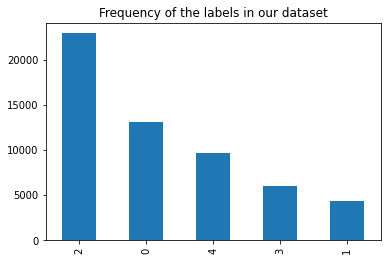

In [11]:
pd.Series(y).value_counts().plot.bar()
plt.title("Frequency of the labels in our dataset")

In [12]:
# print(y[60])
# b1=np.squeeze(np.asarray(np.where(y==1)),axis=0)
# b2=np.asarray(np.where(y==2))
# print(b2.shape)
# index2 = np.random.choice(np.squeeze(b2,axis=0), 4000, replace=False)
# print(index2)
# dd1=np.sort(np.concatenate((b1,index2)))
# c=y[dd1]
# pd.Series(c).value_counts().plot.bar()
# plt.title("Frequency of the labels in our dataset")

# b2=np.asarray(np.where(y==2))
# index2 = np.random.choice(np.squeeze(b2,axis=0), 3000, replace=False)
# b0=np.asarray(np.where(y==0))
# index0 = np.random.choice(np.squeeze(b0,axis=0), 2000, replace=False)
# b4=np.asarray(np.where(y==4))
# index4 = np.random.choice(np.squeeze(b4,axis=0), 1000, replace=False)
# b1=np.squeeze(np.asarray(np.where(y==1)),axis=0)
# #b3=np.squeeze(np.asarray(np.where(y==3)),axis=0)
# b3=np.asarray(np.where(y==3))
# index3 = np.random.choice(np.squeeze(b3,axis=0), 1000, replace=False)

# print(index4.shape)
# dd=np.concatenate((index2,index0,index4,b1,index3))
# #dd=np.concatenate((index2,index0))
# print(dd.shape)
# final_list=dd.tolist()
# print(final_list)
# X=X[final_list,:,:]
# y=y[final_list]
# # print(a.shape)
# # print(c)
# pd.Series(y).value_counts().plot.bar()
# plt.title("Frequency of the labels in our dataset")

In [13]:

# b1=np.squeeze(np.asarray(np.where(y==1)),axis=0)
# print(b1)
# #print(index4.shape)
# #dd=np.concatenate((b1))
# #dd=np.concatenate((index2,index0))
# #print(dd.shape)
# final_list=b1
# print(final_list)
# X1=X[final_list,:,:]
# y1=y[final_list]
# # print(a.shape)
# # print(c)
# pd.Series(y1).value_counts().plot.bar()
# plt.title("Frequency of the labels in our dataset")

In [14]:
# print(y1)
# pd.Series(y1).value_counts().plot.bar()
# print(y)
#pd.Series(y).value_counts().plot.bar()

In [15]:
VBS = True 

In [16]:
from sklearn.model_selection import train_test_split
if VBS:
    print("Shape of the input data: {}".format(X.shape))
    print("Shape of the sleep stages: {}".format(y.shape))
# splitting subjects
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.1, random_state=seed)
X_train_fpz_cz, X_test_fpz_cz, Y_train_fpz_cz, Y_test_fpz_cz = train_test_split(X[:,:,0:1], y, test_size=0.1, random_state=seed)
X_train_pz_oz, X_test_pz_oz, Y_train_pz_oz, Y_test_pz_oz = train_test_split(X[:,:,1:2], y, test_size=0.1, random_state=seed)

if VBS:
    print("Shape of the training dataset:\ntraining dataset: {}\ntest dataset: {}\n"
          .format(X_train.shape, X_test.shape))
    print("Shape of the training dataset:\ntraining fpz_cz dataset: {}\ntest fpz_cz dataset: {}\n"
          .format(X_train_fpz_cz.shape, X_test_fpz_cz.shape))
    print("Shape of the training dataset:\ntraining pz_oz dataset: {}\ntest pz_oz dataset: {}\n"
          .format(X_train_pz_oz.shape, X_test_pz_oz.shape))
    
#print(y_train)


Shape of the input data: (55989, 3000, 2)
Shape of the sleep stages: (55989,)
Shape of the training dataset:
training dataset: (50390, 3000, 2)
test dataset: (5599, 3000, 2)

Shape of the training dataset:
training fpz_cz dataset: (50390, 3000, 1)
test fpz_cz dataset: (5599, 3000, 1)

Shape of the training dataset:
training pz_oz dataset: (50390, 3000, 1)
test pz_oz dataset: (5599, 3000, 1)



In [17]:
# !pip install git+https://www.github.com/keras-team/keras-contrib.git

In [18]:
# from tensorflow import keras
# # from tensorflow.keras import optimizers, losses
# from tensorflow.keras.utils import to_categorical


# y_train_ = to_categorical(y_train)
# y_val_ = to_categorical(y_val)
# y_test_ = to_categorical(y_test)
#print(y_train)

# from tensorflow.keras import optimizers, losses, activations, models
# from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.layers import GlobalMaxPool1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D, TimeDistributed, Bidirectional, LSTM
# from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, MaxPool1D, Activation
# from tensorflow.keras.layers import Reshape, LSTM, TimeDistributed, Bidirectional, BatchNormalization, Flatten, RepeatVector
# from tensorflow.keras.optimizers import Adam
# from keras_contrib.layers import CRF

# from scipy.signal import butter, lfilter

# WINDOW_SIZE = 100
# Fs = 100

# def rescale_array(X):
#     X = X / 20
#     X = np.clip(X, -5, 5)
#     return X

# def aug_X(X):
#     scale = 1 + np.random.uniform(-0.1, 0.1)
#     offset = np.random.uniform(-0.1, 0.1)
#     noise = np.random.normal(scale=0.05, size=X.shape)
#     X = scale * X + offset + noise
#     return X

# def gen(dict_files, scale=True, aug=False):
#     while True:
#         record_name = random.choice(list(dict_files.keys()))
#         batch_data = dict_files[record_name]
#         all_rows = batch_data['x']

#         for i in range(10):
#             start_index = random.choice(range(all_rows.shape[0]-WINDOW_SIZE))

#             X = all_rows[start_index:start_index+WINDOW_SIZE, ...]
#             Y = batch_data['y'][start_index:start_index+WINDOW_SIZE]

#             X = np.expand_dims(X, 0)
#             Y = np.expand_dims(Y, -1)
#             Y = np.expand_dims(Y, 0)

#             if aug:
#                 X = aug_X(X)
                
#             if scale:
#                 X = rescale_array(X)

#             yield np.squeeze(X, axis=0), np.squeeze(Y, axis=0)

# def data_generator(X_samples, y_samples, bs=32, label=True):
#     i = 0
# #     X_samples = X_samples[:]
# #     y_samples = y_samples[:]
#     while True:
#         X_temp = X_samples[i:i + bs]
#         y_temp = y_samples[i:i + bs]
        
#         X_temp = np.array([rescale_array(sample) for sample in X_temp])
#         y_temp = np.array(y_temp)
#         if label:
#             yield X_temp, y_temp
#         else:
#             yield X_temp

#         i += bs           
        

# def model_b(n_classes=5, use_sub_layer=False, use_rnn=True, verbose=False):
#     """Recurrent_Deep_Neural_Networks_for_Real-Time_Sleep
#     """
#     inputLayer = Input(shape=(3000, 1), name='inLayer')
#     convFine = Conv1D(filters=64, kernel_size=int(Fs/2), strides=int(Fs/16), padding='same', activation='relu', name='fConv1')(inputLayer)
#     convFine = MaxPool1D(pool_size=8, strides=8, name='fMaxP1')(convFine)
#     convFine = Dropout(rate=0.5, name='fDrop1')(convFine)
#     convFine = Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', name='fConv2')(convFine)
#     convFine = Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', name='fConv3')(convFine)
#     convFine = Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', name='fConv4')(convFine)
#     convFine = MaxPool1D(pool_size=4, strides=4, name='fMaxP2')(convFine)
#     fineShape = convFine.get_shape()
#     convFine = Flatten(name='fFlat1')(convFine)
    
#     # network to learn coarse features
#     convCoarse = Conv1D(filters=32, kernel_size=Fs*4, strides=int(Fs/2), padding='same', activation='relu', name='cConv1')(inputLayer)
#     convCoarse = MaxPool1D(pool_size=4, strides=4, name='cMaxP1')(convCoarse)
#     convCoarse = Dropout(rate=0.5, name='cDrop1')(convCoarse)
#     convCoarse = Conv1D(filters=128, kernel_size=6, padding='same', activation='relu', name='cConv2')(convCoarse)
#     convCoarse = Conv1D(filters=128, kernel_size=6, padding='same', activation='relu', name='cConv3')(convCoarse)
#     convCoarse = Conv1D(filters=128, kernel_size=6, padding='same', activation='relu', name='cConv4')(convCoarse)
#     convCoarse = MaxPool1D(pool_size=2, strides=2, name='cMaxP2')(convCoarse)
#     coarseShape = convCoarse.get_shape()
#     convCoarse = Flatten(name='cFlat1')(convCoarse)
    
#     # concatenate coarse and fine cnns
#     mergeLayer = concatenate([convFine, convCoarse], name='merge_1')
#     outLayer = Dropout(rate=0.5, name='mDrop1')(mergeLayer)
    
#     outLayer = Reshape((1, outLayer.get_shape()[1]), name='reshape1')(outLayer)
#     outLayer = LSTM(64, return_sequences=True)(outLayer)
#     outLayer = LSTM(64, return_sequences=False)(outLayer)

#     # Classify
#     outLayer = Dense(n_classes, activation='softmax', name='outLayer')(outLayer)
#     model = Model(inputLayer, outLayer)
#     optimizer = Adam(lr=1e-4)
#     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
#     if verbose:
#         model.summary()
#     return model

# def evaluate_metrics(cm,classes):

#     print ("Confusion matrix:")
#     print (cm)

#     cm = cm.astype(np.float32)
#     FP = cm.sum(axis=0) - np.diag(cm)
#     FN = cm.sum(axis=1) - np.diag(cm)
#     TP = np.diag(cm)
#     TN = cm.sum() - (FP + FN + TP)
#     # https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
#     # Sensitivity, hit rate, recall, or true positive rate
#     TPR = TP / (TP + FN)
#     # Specificity or true negative rate
#     TNR = TN / (TN + FP)
#     # Precision or positive predictive value
#     PPV = TP / (TP + FP)
#     # Negative predictive value
#     NPV = TN / (TN + FN)
#     # Fall out or false positive rate
#     FPR = FP / (FP + TN)
#     # False negative rate
#     FNR = FN / (TP + FN)
#     # False discovery rate
#     FDR = FP / (TP + FP)

#     # Overall accuracy
#     ACC = (TP + TN) / (TP + FP + FN + TN)
#     # ACC_micro = (sum(TP) + sum(TN)) / (sum(TP) + sum(FP) + sum(FN) + sum(TN))
#     ACC_macro = np.mean(ACC) # to get a sense of effectiveness of our method on the small classes we computed this average (macro-average)

#     F1 = (2 * PPV * TPR) / (PPV + TPR)
#     F1_macro = np.mean(F1)

#     print ("Sample: {}".format(int(np.sum(cm))))
#     n_classes = len(classes)
#     for index_ in range(n_classes):
#         print ("{}: {}".format(classes[index_], int(TP[index_] + FN[index_])))


#     return ACC_macro,ACC, F1_macro, F1, TPR, TNR, PPV
    
# #train
# def butter_bandpass(lowcut, highpass, fs, order=4):
#     nyq = 0.5 * fs
#     #       low = lowcut / nyq
#     high = highpass / nyq
#     b, a = butter(order, high, btype='highpass')
#     return b, a
   
# def butter_bandpass_filter(data, highpass, fs, order=4):
#     b, a = butter_bandpass(0, highpass, fs, order=order)
#     y = lfilter(b, a, data)
#     return y 

In [19]:

# pp_X_train = np.array([butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4) for sample in X_train])
# pp_X_val = np.array([butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4) for sample in X_val])
# pp_X_test = np.array([butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4) for sample in X_test])
# # pp_X_test = np.expand_dims(pp_X_test, axis=2)
# # pp_X_train = np.expand_dims(pp_X_train, axis=2)
# # pp_X_val = np.expand_dims(pp_X_val, axis=2)
# if VBS:
#     print(pp_X_val.shape)
#     print(pp_X_train.shape)
#     print(X_train.shape)
#     print(X_val.shape)

In [20]:
# from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
# checkpoint = ModelCheckpoint("model_cps", monitor='val_loss', verbose=1, save_best_only=True, mode='max')
# redonplat = ReduceLROnPlateau(monitor="val_loss", mode="max", patience=5, verbose=2)
# csv_logger = CSVLogger('log_training.csv', append=True, separator=',')
# callbacks_list = [
#     checkpoint,
#     redonplat,
#     csv_logger,
# ]

In [21]:
# model_cnn = model_b(verbose=VBS)
# hist_19 = model_cnn.fit(
#     pp_X_train, y_train_, batch_size=batch_size, epochs=30, validation_data=(pp_X_val, y_val_), callbacks=callbacks_list, verbose=VBS
# )

In [22]:
from torch.utils.data import Dataset
class EEGDataset(Dataset):

    def __init__(self, a):
        """
        TODO: init the Dataset instance.
        """
        self.X = a[0]
        self.Y = a[1]

    def __len__(self):
        """
        TODO: Denotes the total number of samples
        """

        return len(self.Y)

    def __getitem__(self, i):
        return (self.X[i], self.Y[i])

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# class MintNet(nn.Module):
#     def __init__(self, n=6):
#         """
#         TODO : documents
#         """
#         super(MintNet, self).__init__()
#         '''
#         Representation layer (initialization)
#         '''
#         Fs = 100
#         self.conv_1 = nn.Conv1d(in_channels=n, out_channels=64, kernel_size=int(Fs / 2), stride=int(Fs / 16), padding=int(Fs / 4) -1)
#         self.pool_1 = nn.MaxPool1d(kernel_size=8, stride=8)
#         self.droput_1 = nn.Dropout(p=.5)
#         self.conv_2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=8, padding=4)
#         self.conv_3 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=8, padding=4)
#         self.conv_4 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=8, padding=4)
#         self.pool_2 = nn.MaxPool1d(kernel_size=4, stride=4)

#         '''
#         Representation layer (Fine-tuning)
#         '''
#         self.conv_1_ft = nn.Conv1d(in_channels=n, out_channels=32, kernel_size=int(Fs * 4), stride=int(Fs / 2), padding=int(Fs*2) -1)
#         self.pool_1_ft = nn.MaxPool1d(kernel_size=4, stride=4)
#         self.conv_2_ft = nn.Conv1d(in_channels=32, out_channels=128, kernel_size=6, padding=3)
#         self.conv_3_ft = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=6, padding=3)
#         self.conv_4_ft = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=6, padding=3)
#         self.pool_2_ft = nn.MaxPool1d(kernel_size=2, stride=2)

#         '''
#         TODO - Some reshaping, We are not sure :)
#         '''
#         self.lstm_1 = nn.LSTM(input_size=1, hidden_size=512, num_layers=1, bidirectional=False)
#         self.lstm_2 = nn.LSTM(input_size=512, hidden_size=1, num_layers=1, bidirectional=False)

#         '''
#         Fully Connected
#         '''

#         self.fc = nn.Linear(in_features=3200, out_features=5)

#     def forward(self, input, dev):
#         input = input.permute(0,2,1).to(dev)
#         #input = input.unsqueeze(dim=-1).permute(0,2,1).to(dev)
#         #print(input.shape)
#         x = self.conv_1(input)
#         x = F.relu(x)
#         x = self.pool_1(x)
#         x = self.droput_1(x)
#         x = F.relu(self.conv_2(x))
#         x = F.relu(self.conv_3(x))
#         x = F.relu(self.conv_4(x))
#         x = self.pool_2(x)
#         x = torch.flatten(x, start_dim=1)

#         x_hat = self.conv_1_ft(input)
#         x_hat = F.relu(x_hat)
#         x_hat = self.pool_1_ft(x_hat)
#         x_hat = self.droput_1(x_hat)
#         x_hat = F.relu(self.conv_2_ft(x_hat))
#         x_hat = F.relu(self.conv_3_ft(x_hat))
#         x_hat = F.relu(self.conv_4_ft(x_hat))
#         x_hat = self.pool_2_ft(x_hat)
#         x_hat = torch.flatten(x_hat, start_dim=1)
#         merged_layers = torch.cat((x, x_hat), dim=-1)
#         out_hat = self.droput_1(merged_layers)
#         '''
#         TODO some reshaping required
#         '''

#         out = out_hat.unsqueeze(dim=-1)
#         out, hidden = self.lstm_1(out)
#         out = self.droput_1(out)
#         out, hidden = self.lstm_2(out)
#         out = self.droput_1(out)

#         # fc_input = out_hat.unsqueeze(dim=-1)
#         #
#         # out_hat = self.fc(fc_input)#correct this out must be from after merged_layer
#         #
#         # merged_layers = torch.cat((out, out_hat), dim=-1)
      
#         out = self.fc(out.squeeze(dim=-1))
#         out = self.droput_1(out)
#         #out = F.softmax(out, dim=1)

#         return out

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

BATCH_SIZE = 50
# train & test data from fpz-cz and pz_oz
X_train = torch.tensor(X_train).float().detach().clone()
Y_train = torch.tensor(Y_train).long().detach().clone()
train_data_all = (X_train, Y_train)

X_test = torch.tensor(X_test).float().detach().clone()
Y_test = torch.tensor(Y_test).long().detach().clone()
test_data_all = (X_test, Y_test)

train_loader_all = torch.utils.data.DataLoader(EEGDataset(train_data_all), batch_size=BATCH_SIZE, shuffle=False)
test_loader_all =  torch.utils.data.DataLoader(EEGDataset(test_data_all), batch_size=BATCH_SIZE, shuffle=False)

# train & test data from fpz-cz
X_train_fpz_cz = torch.tensor(X_train_fpz_cz).float().detach().clone()
Y_train_fpz_cz = torch.tensor(Y_train_fpz_cz).long().detach().clone()
train_data_fpz_cz = (X_train_fpz_cz, Y_train_fpz_cz)

X_test_fpz_cz = torch.tensor(X_test_fpz_cz).float().detach().clone()
Y_test_fpz_cz = torch.tensor(Y_test_fpz_cz).long().detach().clone()
test_data_fpz_cz = (X_test_fpz_cz, Y_test_fpz_cz)

train_loader_fpz_cz = torch.utils.data.DataLoader(EEGDataset(train_data_fpz_cz), batch_size=BATCH_SIZE, shuffle=False)
test_loader_fpz_cz =  torch.utils.data.DataLoader(EEGDataset(test_data_fpz_cz), batch_size=BATCH_SIZE, shuffle=False)

# train & test data from pz-oz
X_train_pz_oz = torch.tensor(X_train_pz_oz).float().detach().clone()
Y_train_pz_oz = torch.tensor(Y_train_pz_oz).long().detach().clone()
train_data_pz_oz = (X_train_pz_oz, Y_train_pz_oz)

X_test_pz_oz= torch.tensor(X_test_pz_oz).float().detach().clone()
Y_test_pz_oz = torch.tensor(Y_test_pz_oz).long().detach().clone()
test_data_pz_oz = (X_test_pz_oz, Y_test_pz_oz)

train_loader_pz_oz = torch.utils.data.DataLoader(EEGDataset(train_data_pz_oz), batch_size=BATCH_SIZE, shuffle=False)
test_loader_pz_oz =  torch.utils.data.DataLoader(EEGDataset(test_data_pz_oz), batch_size=BATCH_SIZE, shuffle=False)

In [25]:

def calculate_batch_accuracy_precision_recall_fscore(y_pred, y_true):
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support

    y_pred = torch.argmax(y_pred, dim=-1)
    y_pred = y_pred.cpu().data.numpy()
    y_true = y_true.cpu().data.numpy()
    (precision, recall, fscore, _) = precision_recall_fscore_support(y_true, y_pred, average='macro',warn_for=tuple())
    accuracy = accuracy_score(y_pred, y_true)
    #print(precision, recall, fscore)
    return precision, recall, fscore, accuracy

def train_model(model, train_loader, n_epoch=5, lr=0.003, device=None):
    import torch.optim as optim
    """
    Comments goes here
    """
    device = device or torch.device('cpu')
   
    loss_history = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    model.train()
    epoch_precision_hist, epoch_recall_hist, epoch_fscore_hist, epoch_accuracy_hist = ([] for i in range(4))

    #X2 = torch.tensor(X1,dtype=torch.float32)
    #y2 = torch.tensor(y1,dtype=torch.long)

    #print(y2.size)

    for epoch in range(n_epoch):
        curr_epoch_loss = []
        precision, recall, fscore, accuracy = ([] for i in range(4))
        count = 0
        for X, Y in train_loader:
            optimizer.zero_grad()
            
            # perm = torch.randperm(y2.size(0))
            # idx = perm[:10]
            # X3 = X2[idx]
            # y3 = y2[idx]
            # X = torch.cat((X,X3),dim=0)
            # Y = torch.cat((Y,y3),dim=0)


            #X = X.squeeze(dim=0).to(device)
            X = X.detach().clone().to(device)
            Y = Y.detach().clone().to(device)
            Y_hat = model(X, device).float()
            Y = Y.long()
            loss = criterion(Y_hat, Y)
            loss.backward()
            optimizer.step()     
            # Appending loss     
            curr_epoch_loss.append(loss.cpu().data.numpy())
            # measure all metrics
            batch_precision, batch_recall, batch_fscore, batch_acc = calculate_batch_accuracy_precision_recall_fscore(Y_hat, Y)
            accuracy.append(batch_acc)
            fscore.append(batch_fscore)
            recall.append(batch_recall)
            precision.append(batch_precision)
            count+=1
            #print(count,"/",len(train_loader),"---lr->",lr,"---------acc->", batch_acc, "  --- loss ->", loss)
            print(f"\repoch{epoch} | progress->{count}/{len(train_loader)} ", end="")
        epoch_accuracy = np.mean(accuracy)
        epoch_accuracy_hist.append(epoch_accuracy)
        epoch_precision_hist.append(np.mean(precision))
        epoch_recall_hist.append(np.mean(recall))
        epoch_fscore_hist.append(np.mean(fscore))
        print(f"curr_epoch_loss={round(np.mean(curr_epoch_loss),2)}")
        loss_history.append(round(np.mean(curr_epoch_loss),2))
        print(datetime.now().strftime("%Y-%m-%d %H:%M"), "epoch_accuracy->", round(epoch_accuracy,2))
        exp_lr_scheduler.step()
        ## Evaluating on every epoch
        # pred, truth = eval_model(model, val_loader, device=device)
        # auroc, f1 = evaluate_predictions(truth, pred)
        # print(f"AUROC={auroc} and F1={f1}")
    return model, loss_history, epoch_accuracy_hist, epoch_precision_hist, epoch_recall_hist, epoch_fscore_hist

In [26]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class SleepCNN_1D_Tsinalis(nn.Module):
#     """Replication of the CNN architecture used by Tsinalis,et al. (2016)
#     https://arxiv.org/pdf/1610.01683.pdf
#     """

#     def __init__(self, n = 1):
#         super(SleepCNN_1D_Tsinalis, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels=n, out_channels=20, kernel_size=200, stride=1)
#         self.pool1 = nn.MaxPool1d(kernel_size=20, stride=10)
#         self.conv2 = nn.Conv2d(
#             in_channels=1, out_channels=400, kernel_size=(20, 30), stride=(1, 1))
#         self.pool2 = nn.MaxPool2d(kernel_size=(1, 10), stride=(1, 2))
#         #self.fc1 = nn.Linear(in_features=400 * 721, out_features=500)
#         self.fc1 = nn.Linear(in_features=400 * 121, out_features=500)
#         self.fc2 = nn.Linear(in_features=500, out_features=5)

#     def forward(self, x, dev):
#         x = x.permute(0,2,1).to(dev)
#         # One dimensional convolution/pooling
#         x = F.relu(self.conv1(x))
#         x = self.pool1(x)

#         # Stack, two-dimensional convolution/pooling
#         x = x.unsqueeze(1)
#         x = F.relu(self.conv2(x))
#         x = self.pool2(x)
#         #print(x.shape)
#         # Reshape, fully connected layers
#         x = x.view(-1, 400 * 121)#400 * 721)
#         x = self.fc1(x)
#         x = self.fc2(x)

#         return x

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SleepCNN_1D_Tsinalis(nn.Module):
    """Replication of the CNN architecture used by Tsinalis,et al. (2016)
    https://arxiv.org/pdf/1610.01683.pdf
    """

    def __init__(self, n = 1):
        super(SleepCNN_1D_Tsinalis, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=n, out_channels=20, kernel_size=200, stride=1)
        self.bn1 = nn.BatchNorm1d(num_features=20)
        self.pool1 = nn.MaxPool1d(kernel_size=20, stride=10)
        self.conv2 = nn.Conv2d(
            in_channels=1, out_channels=400, kernel_size=(20, 30), stride=(1, 1))
        self.bn2 = nn.BatchNorm2d(num_features=400)
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 10), stride=(1, 2))

        self.conv3 = nn.Conv2d(in_channels=400, out_channels=100, kernel_size=(1,10),stride=(1,1))
        self.bn3 = nn.BatchNorm2d(num_features=100)
        self.pool3 = nn.MaxPool2d(kernel_size=(1, 10), stride=(5, 7))

        #self.fc1 = nn.Linear(in_features=400 * 121, out_features=500)
        self.fc1 = nn.Linear(in_features=100*15, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=5)

    def forward(self, x, dev):
        x = x.permute(0,2,1).to(dev)
        #print("1-->",x.shape)
        # One dimensional convolution/pooling
        x = self.conv1(x)
        #print("2-->",x.shape)
        x = self.bn1(x)
        #print("3-->",x.shape)
        x = F.relu(x)
        #print("4-->",x.shape)
        x = self.pool1(x)
        #print("5-->",x.shape)

        # Stack, two-dimensional convolution/pooling
        x = x.unsqueeze(1)
#         print("6-->",x.shape)

              # 2--> torch.Size([50, 20, 2801])
              # 3--> torch.Size([50, 20, 2801])
              # 4--> torch.Size([50, 20, 2801])
              # 5--> torch.Size([50, 20, 279])
              # 6--> torch.Size([50, 1, 20, 279])
              # 7--> torch.Size([50, 400, 1, 250])
              # 8--> torch.Size([50, 400, 1, 250])
              # 9--> torch.Size([50, 400, 1, 250])
              # 10--> torch.Size([50, 400, 1, 121])
        x = self.conv2(x)
        #print("7-->",x.shape)
        x = self.bn2(x)
        #print("8-->",x.shape)
        x = F.relu(x)
        #print("9-->",x.shape)
        x = self.pool2(x)
        #print("10-->",x.shape)

        #x=x.permute(0,2,1,3)
        #print(x.shape)
        x = self.conv3(x)
        #print("11-->",x.shape)
        x = self.bn3(x)
        #print("12-->",x.shape)
        x = F.relu(x)
        #print("13-->",x.shape)
        x = self.pool3(x)
        #print("14-->",x.shape)

        #print(x.shape)
        # Reshape, fully connected layers
        x = x.view(-1,100*15)#400 * 721)
        x = self.fc1(x)
        x = self.fc2(x)

        return x

In [65]:
print(torch.cuda.is_available())
if torch.cuda.is_available():
  dev = "cuda:0"
  torch.cuda.empty_cache()
else:
  dev = "cpu"
device = torch.device(dev)
print(datetime.now().strftime("%Y-%m-%d %H:%M"))

# All the channel
n_epoch = 20#10
lr = .0001#0.003

n_dim=2#number of channels which includes fpz-cz and pz-oz

model = SleepCNN_1D_Tsinalis(n_dim)#MintNet(n_dim)
model = model.to(device)

model, loss_history, epoch_accuracy_hist, epoch_precision_hist, epoch_recall_hist, epoch_fscore_hist = train_model(model, train_loader_all, n_epoch=n_epoch, lr=lr, device=device)
torch.save(model, os.path.join(project_path, "SleepCNN_multichannel.pth"))


True
2021-04-23 21:33
epoch0 | progress->1008/1008 curr_epoch_loss=0.5799999833106995
2021-04-23 21:33 epoch_accuracy-> 0.78
epoch1 | progress->1008/1008 curr_epoch_loss=0.4699999988079071
2021-04-23 21:33 epoch_accuracy-> 0.82
epoch2 | progress->1008/1008 curr_epoch_loss=0.4399999976158142
2021-04-23 21:33 epoch_accuracy-> 0.83
epoch3 | progress->1008/1008 curr_epoch_loss=0.3799999952316284
2021-04-23 21:34 epoch_accuracy-> 0.86
epoch4 | progress->1008/1008 curr_epoch_loss=0.3700000047683716
2021-04-23 21:34 epoch_accuracy-> 0.86
epoch5 | progress->1008/1008 curr_epoch_loss=0.36000001430511475
2021-04-23 21:34 epoch_accuracy-> 0.87
epoch6 | progress->1008/1008 curr_epoch_loss=0.3499999940395355
2021-04-23 21:34 epoch_accuracy-> 0.87
epoch7 | progress->1008/1008 curr_epoch_loss=0.3400000035762787
2021-04-23 21:35 epoch_accuracy-> 0.87
epoch8 | progress->1008/1008 curr_epoch_loss=0.3400000035762787
2021-04-23 21:35 epoch_accuracy-> 0.87
epoch9 | progress->1008/1008 curr_epoch_loss=0.340

In [70]:
#fpz-cz training
print('fpz-cz training', datetime.now().strftime("%Y-%m-%d %H:%M"))
n_epoch = 20#10
lr = .0001#0.003

n_dim=1#number of channels as its fpz-cz

model_fpz_cz = SleepCNN_1D_Tsinalis(n_dim)#MintNet(n_dim)
model_fpz_cz = model_fpz_cz.to(device)

model_fpz_cz, loss_history_fpz_cz, epoch_accuracy_hist_fpz_cz, epoch_precision_hist_fpz_cz, epoch_recall_hist_fpz_cz, epoch_fscore_hist_fpz_cz = train_model(model_fpz_cz, train_loader_fpz_cz, n_epoch=n_epoch, lr=lr, device=device)
torch.save(model_fpz_cz, os.path.join(project_path, "SleepCNN_fpz_cz_channel.pth"))

fpz-cz training 2021-04-23 21:40
epoch0 | progress->1008/1008 curr_epoch_loss=0.6299999952316284
2021-04-23 21:41 epoch_accuracy-> 0.75
epoch1 | progress->1008/1008 curr_epoch_loss=0.5199999809265137
2021-04-23 21:41 epoch_accuracy-> 0.8
epoch2 | progress->1008/1008 curr_epoch_loss=0.49000000953674316
2021-04-23 21:41 epoch_accuracy-> 0.81
epoch3 | progress->1008/1008 curr_epoch_loss=0.4300000071525574
2021-04-23 21:42 epoch_accuracy-> 0.84
epoch4 | progress->1008/1008 curr_epoch_loss=0.41999998688697815
2021-04-23 21:42 epoch_accuracy-> 0.84
epoch5 | progress->1008/1008 curr_epoch_loss=0.4099999964237213
2021-04-23 21:42 epoch_accuracy-> 0.84
epoch6 | progress->1008/1008 curr_epoch_loss=0.4000000059604645
2021-04-23 21:43 epoch_accuracy-> 0.85
epoch7 | progress->1008/1008 curr_epoch_loss=0.4000000059604645
2021-04-23 21:43 epoch_accuracy-> 0.85
epoch8 | progress->1008/1008 curr_epoch_loss=0.4000000059604645
2021-04-23 21:44 epoch_accuracy-> 0.85
epoch9 | progress->1008/1008 curr_epoch

In [71]:
#pz-oz training
print('pz-oz training', datetime.now().strftime("%Y-%m-%d %H:%M"))
n_epoch = 20#10
lr = .0001#0.003

n_dim=1#number of channels as its pz-oz

model_pz_oz = SleepCNN_1D_Tsinalis(n_dim)#MintNet(n_dim)
model_pz_oz = model_pz_oz.to(device)

model_pz_oz, loss_history_pz_oz, epoch_accuracy_hist_pz_oz, epoch_precision_hist_pz_oz, epoch_recall_hist_pz_oz, epoch_fscore_hist_pz_oz = train_model(model_pz_oz, train_loader_pz_oz, n_epoch=n_epoch, lr=lr, device=device)
torch.save(model_pz_oz, os.path.join(project_path, "SleepCNN_pz_oz_channel.pth"))

pz-oz training 2021-04-23 21:48
epoch0 | progress->1008/1008 curr_epoch_loss=0.7099999785423279
2021-04-23 21:48 epoch_accuracy-> 0.73
epoch1 | progress->1008/1008 curr_epoch_loss=0.6100000143051147
2021-04-23 21:49 epoch_accuracy-> 0.77
epoch2 | progress->1008/1008 curr_epoch_loss=0.5799999833106995
2021-04-23 21:49 epoch_accuracy-> 0.78
epoch3 | progress->1008/1008 curr_epoch_loss=0.5299999713897705
2021-04-23 21:49 epoch_accuracy-> 0.8
epoch4 | progress->1008/1008 curr_epoch_loss=0.5199999809265137
2021-04-23 21:50 epoch_accuracy-> 0.81
epoch5 | progress->1008/1008 curr_epoch_loss=0.5099999904632568
2021-04-23 21:50 epoch_accuracy-> 0.81
epoch6 | progress->1008/1008 curr_epoch_loss=0.5
2021-04-23 21:50 epoch_accuracy-> 0.82
epoch7 | progress->1008/1008 curr_epoch_loss=0.49000000953674316
2021-04-23 21:51 epoch_accuracy-> 0.82
epoch8 | progress->1008/1008 curr_epoch_loss=0.49000000953674316
2021-04-23 21:51 epoch_accuracy-> 0.82
epoch9 | progress->1008/1008 curr_epoch_loss=0.49000000

Text(0, 0.5, 'loss')

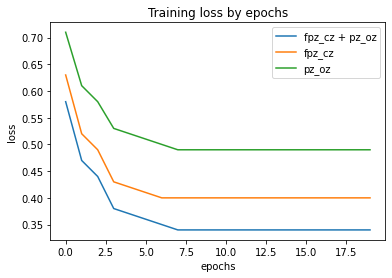

In [72]:
plt.title("Training loss by epochs")
plt.plot(loss_history, label = "fpz_cz + pz_oz")
plt.plot(loss_history_fpz_cz, label = "fpz_cz")
plt.plot(loss_history_pz_oz, label = "pz_oz")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

Text(0, 0.5, 'accuracy')

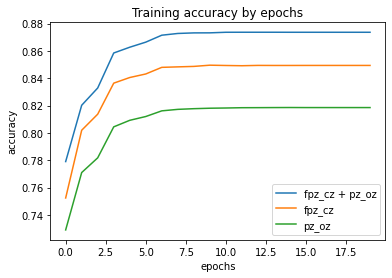

In [73]:
plt.title("Training accuracy by epochs")
plt.plot(epoch_accuracy_hist,label = "fpz_cz + pz_oz")
plt.plot(epoch_accuracy_hist_fpz_cz, label = "fpz_cz")
plt.plot(epoch_accuracy_hist_pz_oz, label = "pz_oz")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("accuracy")

Text(0, 0.5, 'precision')

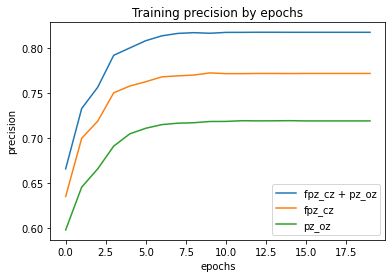

In [74]:
plt.title("Training precision by epochs")
plt.plot(epoch_precision_hist,label = "fpz_cz + pz_oz")
plt.plot(epoch_precision_hist_fpz_cz,label = "fpz_cz")
plt.plot(epoch_precision_hist_pz_oz,label = "pz_oz")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("precision")

Text(0, 0.5, 'recall')

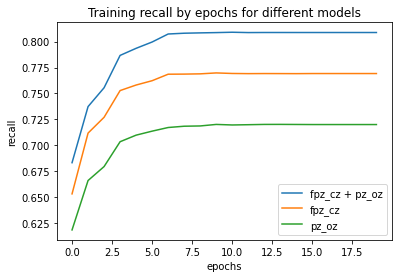

In [75]:
plt.title("Training recall by epochs for different models")
plt.plot(epoch_recall_hist,label = "fpz_cz + pz_oz")
plt.plot(epoch_recall_hist_fpz_cz,label = "fpz_cz")
plt.plot(epoch_recall_hist_pz_oz,label = "pz_oz")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("recall")

Text(0, 0.5, 'f1-score')

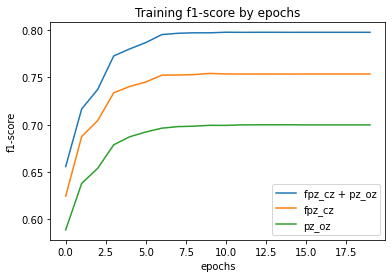

In [76]:
plt.title("Training f1-score by epochs")
plt.plot(epoch_fscore_hist, label = "fpz_cz + pz_oz")
plt.plot(epoch_fscore_hist_fpz_cz, label = "fpz_cz")
plt.plot(epoch_fscore_hist_pz_oz, label = "pz_oz")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("f1-score")

In [77]:
def eval_model(model, dataloader, device=None):
    """
    Comments goes here
    """
    device = device or torch.device('cpu')
    model.eval()
    pred_all = []
    Y_test = []
    for X, Y in dataloader:
        X = X.detach().clone().to(device)
        Y = Y.detach().clone().to(device)
        Y_hat = model(X, device).float()
        Y_hat = torch.softmax(Y_hat, dim=1)
        pred_all.append(Y_hat.cpu().detach().numpy())
        Y_test.append(Y.cpu().detach().numpy())
    pred_all = np.concatenate(pred_all, axis=0)
    Y_test = np.concatenate(Y_test, axis=0)

    return pred_all, Y_test     

def evaluate_predictions(truth, pred):

    from sklearn.metrics import roc_auc_score, f1_score, cohen_kappa_score
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
    from sklearn.metrics import confusion_matrix
  
    pred_hat = np.argmax(pred, axis=1)

    auroc = roc_auc_score(truth, pred, multi_class='ovr')
    f1 = f1_score(truth, pred_hat, average='micro')
    kappa = cohen_kappa_score(truth, pred_hat)


    #(precision, recall, fscore, _) = precision_recall_fscore_support(truth, pred_hat, average='macro',warn_for=tuple())
    accuracy = accuracy_score(pred_hat, truth)
    cm = confusion_matrix(truth, pred_hat)

    return round(auroc,2), round(f1,2), round(kappa,2), round(accuracy,2),cm


In [78]:
print("--------final Eval---of all Channels-----")
pred, truth = eval_model(model, test_loader_all, device=device)
auroc, f1, kappa, accuracy,cm = evaluate_predictions(truth, pred)
print(f"All Channels AUROC={auroc} , F1={f1}, accuracy ={accuracy}, and Cohen's Kappa ={kappa}")
print(cm)


--------final Eval---of all Channels-----
All Channels AUROC=0.97 , F1=0.85, accuracy =0.85, and Cohen's Kappa =0.79
[[1157   36   17    1   20]
 [  69  156  100    1  109]
 [  12   50 2084   65  130]
 [   3    1   93  516    0]
 [  23   42   65    0  849]]


In [79]:
print("--------final Eval---of fpz-cz-----")
pred, truth = eval_model(model_fpz_cz, test_loader_fpz_cz, device=device)
auroc, f1, kappa,accuracy,cm = evaluate_predictions(truth, pred)
print(f"fpz-cz channel AUROC={auroc}, F1={f1}, accuracy ={accuracy}, and Cohen's Kappa ={kappa}")
print(cm)


--------final Eval---of fpz-cz-----
fpz-cz channel AUROC=0.96, F1=0.83, accuracy =0.83, and Cohen's Kappa =0.77
[[1157   28   16    0   30]
 [  96  106   97    0  136]
 [  15   38 2063   68  157]
 [   4    0  103  505    1]
 [  34   43   68    1  833]]


In [80]:
print("--------final Eval---of pz-oz-----")
pred, truth = eval_model(model_pz_oz, test_loader_pz_oz, device=device)
auroc, f1, kappa,accuracy,cm = evaluate_predictions(truth, pred)
print(f"pz-oz channel AUROC={auroc} , F1={f1}, accuracy ={accuracy}, and Cohen's Kappa ={kappa}")
print(cm)

--------final Eval---of pz-oz-----
pz-oz channel AUROC=0.94 , F1=0.8, accuracy =0.8, and Cohen's Kappa =0.72
[[1153   17   26    0   35]
 [ 135   49  103    2  146]
 [  26   18 2030   83  184]
 [   7    0  159  447    0]
 [  58   16   97    1  807]]


In [81]:
print("End of run-->",datetime.now().strftime("%Y-%m-%d %H:%M"))

End of run--> 2021-04-23 21:55
